# Build a concordance map

When evaluating the Teleconnections evaluation for a model, it is important to understand the concordance between the model and the observations.
If the CLI available is run, maps showing the differences beetwen the model and ERA5 will be generated if the flag `--ref` is gave as an argument.

A more accurate estimate of the concordance between the model and the observations can be obtained by building a concordance map.
In order to do this, we first execute a bootstrap on the index timeseries of ERA5 and build regression maps based on this bootstrap.
Then, we evaluate the percentile for each pixel of these maps and build a mask, where the pixels of the model between the 5th and 95th percentile are considered concordant.
Then we can plot together the regression map for the model and the mask, to see where the model is concordant with the observations.

Let's start by evaluating the quantities needed. We will keep here a very low value of the bootstrap to perform just to show the concept. In a real case, we would need to run a bootstrap with a higher number of iterations to get a more accurate estimate of the concordance.

In [1]:
from aqua.diagnostics import Teleconnection

Let's start with ERA5 data, of which we need only the timeseries. We will set regrid to 1 deg to speed up the evaluation and the bootstrap.

In [2]:
tc_ERA = Teleconnection(catalog='obs', model='ERA5', exp='era5', source='monthly', telecname='ENSO',
                        regrid='r100', loglevel='INFO', save_pdf=True, save_png=True, save_netcdf=True)

2024-11-26 20:13:46 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-11-26 20:13:46 :: Teleconnection :: INFO     -> Namelist loaded
2024-11-26 20:13:46 :: ConfigPath :: INFO     -> ERA5_era5_monthly triplet found in in obs!


2024-11-26 20:13:46 :: Reader :: INFO     -> Fix names in metadata is ERA5-destine-v1
2024-11-26 20:13:46 :: Reader :: INFO     -> Fix names ERA5-destine-v1 found in fixes files
2024-11-26 20:13:46 :: Reader :: INFO     -> Grid metadata is era5-r025s
2024-11-26 20:13:48 :: Teleconnection :: INFO     -> Reader initialized


In [3]:
tc_ERA.evaluate_index()
index_ERA = tc_ERA.index

2024-11-26 20:13:48 :: Teleconnection :: INFO     -> No retrieve has been performed, trying to retrieve
2024-11-26 20:13:48 :: Reader :: INFO     -> Retrieving variables: ['avg_tos']
2024-11-26 20:13:50 :: Reader :: INFO     -> Variables to be fixed: {'avg_tos': {'grib': True, 'source': 'SSTK'}}
2024-11-26 20:13:50 :: Reader :: INFO     -> avg_tos: converting units K --> K
2024-11-26 20:13:50 :: Reader :: INFO     -> coordinates adjusted to cf by AQUA fixer
2024-11-26 20:13:50 :: Teleconnection :: INFO     -> Data retrieved
2024-11-26 20:13:50 :: Teleconnection :: INFO     -> Data regridded to r100
2024-11-26 20:13:50 :: Teleconnection :: INFO     -> Index found in .//netcdf/teleconnections.ENSO_index.obs.ERA5.era5.avg_tos.nc
2024-11-26 20:14:22 :: Teleconnection :: INFO     -> Index evaluated
2024-11-26 20:14:22 :: create_folder :: INFO     -> Folder ./netcdf already exists
2024-11-26 20:14:26 :: OutputSaver :: INFO     -> Saved netCDF file to path: ./netcdf/teleconnections.ENSO_index

We do the same for a model to analyze, already regridded to monthly, 1 deg resolution.

In [4]:
tc_model = Teleconnection(catalog='climatedt-phase1', model='IFS-NEMO', exp='ssp370', source='lra-r100-monthly', telecname='ENSO', loglevel='INFO',
                          save_pdf=True, save_png=True, save_netcdf=True)

2024-11-26 20:14:26 :: Teleconnection :: INFO     -> No regrid will be performed, be sure that the data is already at low resolution
2024-11-26 20:14:26 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-11-26 20:14:26 :: Teleconnection :: INFO     -> Namelist loaded
2024-11-26 20:14:27 :: ConfigPath :: INFO     -> IFS-NEMO_ssp370_lra-r100-monthly triplet found in in climatedt-phase1!
2024-11-26 20:14:27 :: Reader :: WARNING  -> FDB_PATH parameter is required but is missing, setting to default 
2024-11-26 20:14:27 :: Reader :: WARNING  -> FDB_PATH_HISTORICAL parameter is required but is missing, setting to default 
2024-11-26 20:14:27 :: Reader :: WARNING  -> FDB_PATH_EERIE parameter is required but is missing, setting to default 
2024-11-26 20:14:27 :: Reader :: WARNING  -> ECCODES_PATH parameter is required but is missing, setting to default 


2024-11-26 20:14:27 :: Reader :: INFO     -> No specific fix found, will call the default fix IFS-NEMO-default
2024-11-26 20:14:27 :: Reader :: WARNING  -> The requested default fixer name IFS-NEMO-default does not exist in fixes files
2024-11-26 20:14:27 :: Reader :: WARNING  -> No fixes available for model IFS-NEMO, experiment ssp370, source lra-r100-monthly
2024-11-26 20:14:27 :: Reader :: INFO     -> Grid metadata is lon-lat
2024-11-26 20:14:27 :: Teleconnection :: INFO     -> Reader initialized


In [5]:
tc_model.evaluate_index()
index_model = tc_model.index

2024-11-26 20:14:27 :: Teleconnection :: INFO     -> No retrieve has been performed, trying to retrieve
2024-11-26 20:14:27 :: Reader :: INFO     -> Retrieving variables: ['avg_tos']
2024-11-26 20:15:10 :: Teleconnection :: INFO     -> Data retrieved
2024-11-26 20:15:11 :: Teleconnection :: INFO     -> Index evaluated
2024-11-26 20:15:11 :: create_folder :: INFO     -> Folder ./netcdf already exists
2024-11-26 20:15:17 :: OutputSaver :: INFO     -> Saved netCDF file to path: ./netcdf/teleconnections.ENSO_index.climatedt-phase1.IFS-NEMO.ssp370.avg_tos.nc


For the model we evaluate the regression map and store it. The bootstrap procedure is available at the moment only for the full year regression, but the bootstrap methodology can be generalized with seasonal regression maps.

In [6]:
reg = tc_model.evaluate_regression()

2024-11-26 20:15:17 :: create_folder :: INFO     -> Folder ./netcdf already exists
2024-11-26 20:15:23 :: OutputSaver :: INFO     -> Saved netCDF file to path: ./netcdf/teleconnections.ENSO_regression.climatedt-phase1.IFS-NEMO.ssp370.nc


The bootstrap is performed with two functions, `bootstrap_teleconnections` and `build_confidence_mask`.
The first one will perform the bootstrap, evaluate the regression maps for each iteration and at the end return the lower and upper percentiles of the regression maps.
The second function will build the mask based on the percentiles.

Let's import the necessary functions:

In [7]:
from aqua.diagnostics.teleconnections import bootstrap_teleconnections, build_confidence_mask

Let's evaluate the bootstrap, please be aware that this should be done in a proper computational node in a script. Here we are just showing the concept.

In [8]:
lower, upper = bootstrap_teleconnections(map=reg, index=index_model, index_ref=index_ERA, data_ref=tc_ERA.data['avg_tos'],
                                         n_bootstraps=10, concordance=0.05, statistic='reg', loglevel='INFO')

Let's plot together the two boundaries:

Text(0.5, 1.0, 'Lower 5% confidence interval')

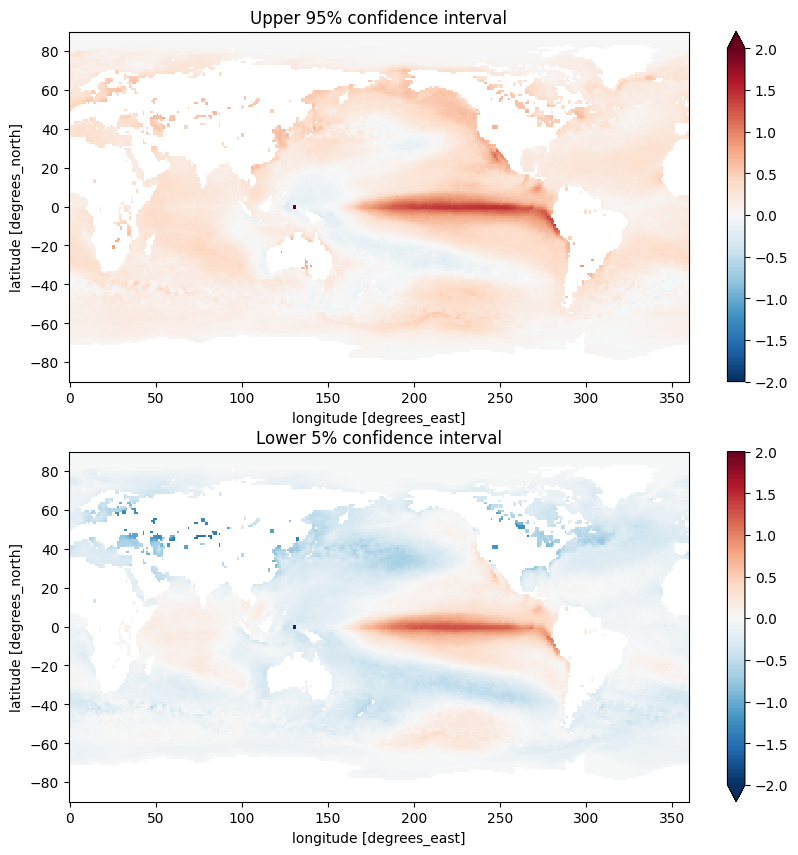

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

upper.plot(ax=ax[0], cmap='RdBu_r', vmin=-2, vmax=2)
ax[0].set_title('Upper 95% confidence interval')
lower.plot(ax=ax[1], cmap='RdBu_r', vmin=-2, vmax=2)
ax[1].set_title('Lower 5% confidence interval')

The mask is then built with the function `build_confidence_mask`.
By default the values are set in the regions where the model is concordant with the observations.
The `mask_concordance` flag can be used to selec the regions where the model is discordant with the observations.

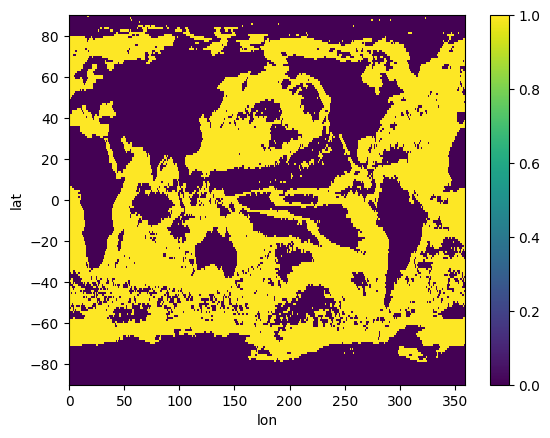

In [10]:
mask = build_confidence_mask(map=reg, lower=lower, upper=upper, mask_concordance=True)
mask.plot()

We can finally plot together the regression map with the mask to see where the model is concordant with the observations.

In [11]:
#from aqua.graphics import plot_single_map
#from aqua.util import add_cyclic_lon

#fig, ax = plot_single_map(reg, transform_first=True, return_fig=True, vmin=-1.4, vmax=1.4)

#mask = add_cyclic_lon(mask) # To make sure the mask is cyclic
#mask.where(mask == 1).plot.contourf(levels=[0, 1], colors='none', hatches=['....', ''], add_colorbar=False, ax=ax)

Finally we can do a simple plot to check the details of the procedure:

Text(0.5, 1.0, 'Upper percentile')

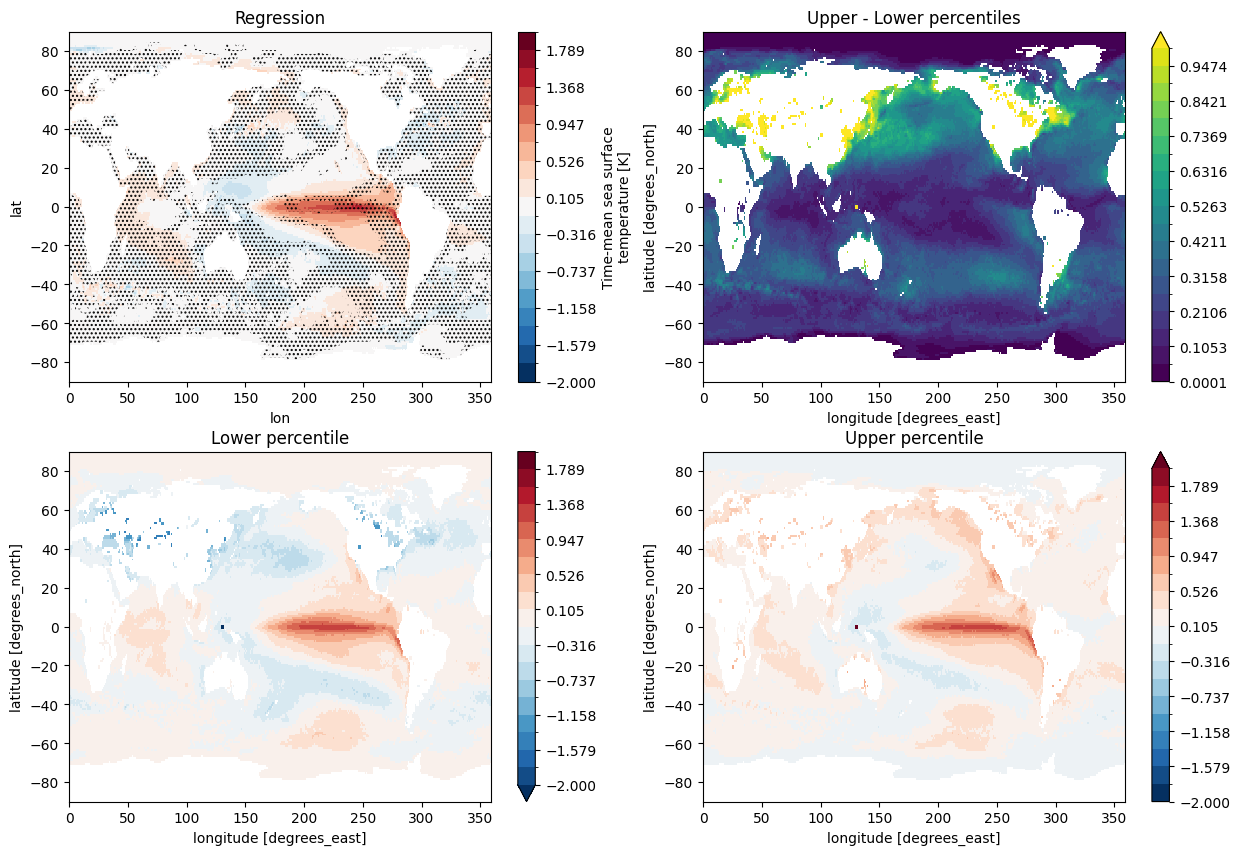

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot map and mask on the first row
reg.plot.pcolormesh(ax=axs[0,0], vmin=-2., vmax=2., cmap='RdBu_r', levels=20)
mask.where(mask == 1).plot.contourf(levels=[0, 1], colors='none', hatches=['....', ''], add_colorbar=False, ax=axs[0,0])

# Plot u-l on the first row
(upper - lower).plot(ax=axs[0, 1], levels=20, vmax=1.)

# Plot lower and upper on the second row
lower.plot(ax=axs[1, 0], vmin=-2., vmax=2., cmap='RdBu_r', levels=20)
upper.plot(ax=axs[1, 1], vmin=-2., vmax=2., cmap='RdBu_r', levels=20)

axs[0, 0].set_title('Regression')
axs[0, 1].set_title('Upper - Lower percentiles')
axs[1, 0].set_title('Lower percentile')
axs[1, 1].set_title('Upper percentile')

As we can see a bigger number of iterations is needed to get a more accurate estimate of the concordance between the model and the observations.